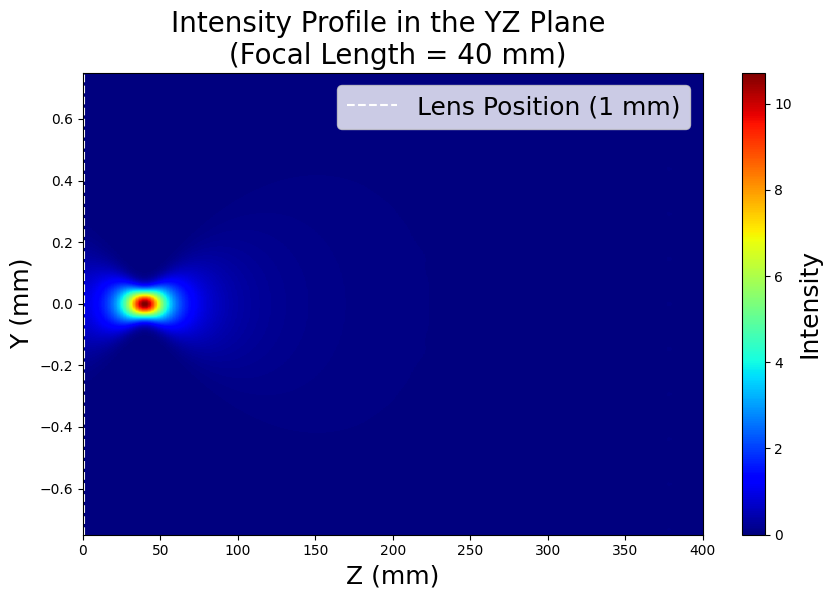

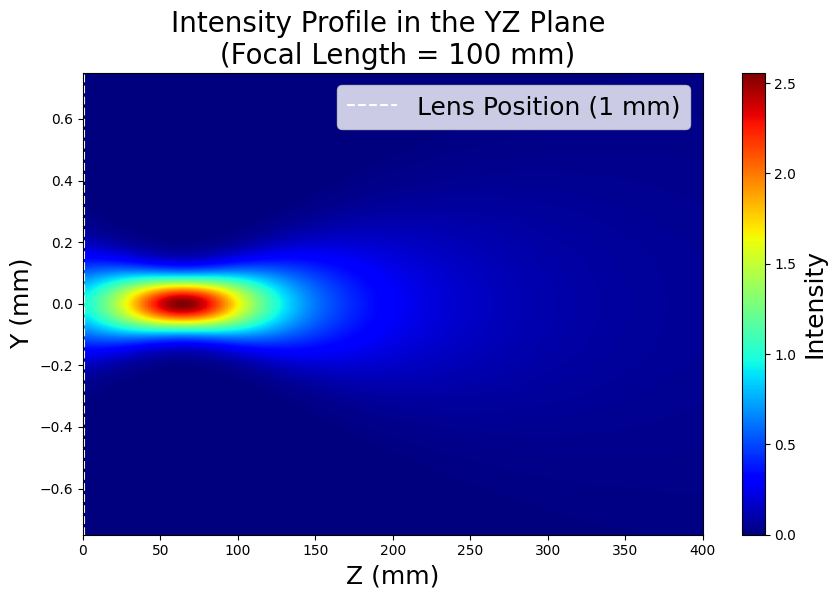

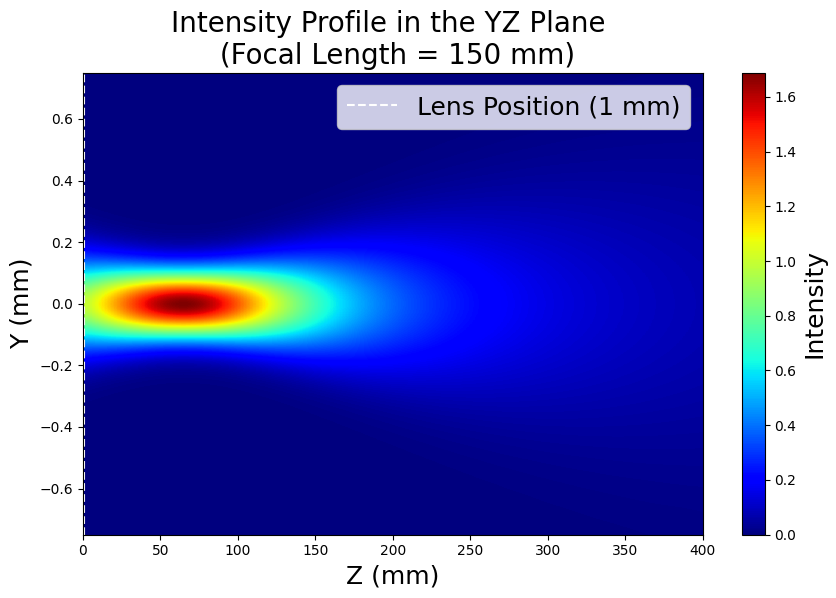

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Beam propagation using angular spectrum method
def angular_spectrum_method_with_padding(field, z_arr, wavelength, dx, dy, pad_width, alpha, bandwidth_limit=True):
    # Propagation constant
    k = 2 * np.pi / wavelength
    
    # Padding on input field to increase the array size
    padded_field = np.pad(field, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant')
    
    # Creating an absorption mask
    Nx, Ny = padded_field.shape
    x = np.linspace(-1, 1, Nx)
    y = np.linspace(-1, 1, Ny)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    absorption_mask = np.exp(-alpha * np.maximum(r - 1 + 2 * pad_width / max(Nx, Ny), np.zeros_like(r))**2)
    
    # Applying the absorption mask
    padded_field *= absorption_mask
    
    # Fourier Transform of the input field
    field_ft = np.fft.fft2(padded_field)
    
    # Spatial frequencies
    kx = np.fft.fftfreq(Nx, dx) * 2 * np.pi
    ky = np.fft.fftfreq(Ny, dy) * 2 * np.pi
    kx, ky = np.meshgrid(kx, ky, indexing="ij")
    
    # Bandwidth limiting
    if bandwidth_limit:
        k_max = k
        mask = (kx**2 + ky**2 <= k_max**2)
        field_ft *= mask
    
    # kz in the frequency domain
    kz = np.sqrt(np.clip(k**2 - kx**2 - ky**2, 0, None))
    
    # Creating an empty array "propagated_fields" with the same shape of "field" array
    propagated_fields = np.empty((len(z_arr), field.shape[0], field.shape[1]), dtype=np.complex128)
    
    # Loop to find propagating field at each point of z
    for count, z in enumerate(z_arr):
        # Propagation phase factor
        phase_factor = np.exp(1j * kz * z)
        
        # Propagated field in the frequency domain
        propagated_field_ft = field_ft * phase_factor
        
        # Inverse Fourier Transform to get the field at distance z
        propagated_field = np.fft.ifft2(propagated_field_ft)
        
        # Removing padding
        propagated_field = propagated_field[pad_width:-pad_width, pad_width:-pad_width]
        propagated_fields[count, :, :] = propagated_field
    
    return propagated_fields

# Parameters
wavelength = 1e-3  # Wavelength in mm
Wo = 0.2  # Beam waist in mm
pad_width = 140  # Padding width
abs_coeff = 16  # Absorption coefficient

# Grid parameters
grid_size = 500
grid_extent = 1.5  # Reduced extent of the grid in mm for finer detail
dx = dy = grid_extent / grid_size

# Lens positions and focal lengths
lens_position = 1  # Position of lens in mm
focal_lengths = [40, 100, 150]  # Focal lengths in mm

# Coordinate grid
x = np.linspace(-grid_extent / 2, grid_extent / 2, grid_size)
y = np.linspace(-grid_extent / 2, grid_extent / 2, grid_size)
X, Y = np.meshgrid(x, y)

# Initial Gaussian beam field
initial_field = np.exp(-(X**2 + Y**2) / Wo**2)

# Array for position in z axis
z_positions = np.linspace(0, 400, 200)

# Plotting for each focal length
for focal_length in focal_lengths:
    # Lens phase transformation function
    lens_phase = np.exp(((-1j * np.pi) / (wavelength * focal_length)) * (X**2 + Y**2))
    
    # 1. Propagate the field to the lens position
    z_to_lens = np.linspace(0, lens_position, 2)
    field_to_lens = angular_spectrum_method_with_padding(initial_field, z_to_lens, wavelength, dx, dy, pad_width, abs_coeff)
    field_at_lens = field_to_lens[-1, :, :]
    
    # 2. Apply the lens phase transformation
    field_after_lens = field_at_lens * lens_phase
    
    # 3. Propagate the field after the lens
    z_after_lens = np.linspace(lens_position, z_positions[-1], len(z_positions) - 1)
    field_after_lens_all_z = angular_spectrum_method_with_padding(field_after_lens, z_after_lens, wavelength, dx, dy, pad_width, abs_coeff)
    
    # Combine fields before and after the lens
    propag_field = np.concatenate((field_to_lens, field_after_lens_all_z), axis=0)
    
    # Compute the intensity profile
    intensity = np.abs(propag_field)**2
    
    # Choose a slice of X (e.g., the center)
    x_center_idx = grid_size // 2
    
    # Extract the intensity profile along the Y and Z axes
    intensity_YZ = intensity[:, :, x_center_idx]
    
    # Transpose the intensity data to swap axes for plotting
    intensity_YZ_transposed = intensity_YZ.T
    
    # Plot the intensity profile with z positions on the x-axis and y coordinates on the y-axis
    plt.figure(figsize=(10, 6))
    img = plt.imshow(intensity_YZ_transposed, extent=[z_positions[0], z_positions[-1], y[0], y[-1]], aspect='auto', cmap='jet')
    
    # Create a colorbar with increased fontsize for the label
    cbar = plt.colorbar(img)
    cbar.set_label('Intensity', fontsize=18)
    
    # Set the axis labels and title
    plt.xlabel('Z (mm)', fontsize=18)
    plt.ylabel('Y (mm)', fontsize=18)
    plt.title(f'Intensity Profile in the YZ Plane \n (Focal Length = {focal_length} mm)', fontsize=20)
    
    # Add a vertical line at the lens position
    plt.axvline(x=lens_position, color='white', linestyle='--', label=f'Lens Position ({lens_position} mm)')
    plt.legend(fontsize=18)
    
    plt.show()
